In [1]:
import cv2
import numpy as np
import os 
import time
import pickle
import inspect

from IPython.display import clear_output
from PIL import Image, ImageDraw

# My custom library of photoelastic tools
import sys
sys.path.append('/eno/jdfeathe/pepe/')
#sys.path.append('/home/jack//workspaces/jupyter-workspace/pepe/')
from pepe.preprocess import crossMask, checkImageType, circularMask, lightCorrectionDiff, rectMask, mergeMasks

from pepe.analysis import initialForceSolve, forceOptimize
from pepe.tracking import houghCircle, convCircle
from pepe.simulate import genSyntheticResponse
from pepe.utils import preserveOrderArgsort, rectangularizeForceArrays
from pepe.visualize import visContacts, visCircles, genRandomDistancedColors, genRandomColors
from pepe.auto import forceSolve

import progressbar

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140


In [5]:
inspect.getfullargspec(visContacts)

FullArgSpec(args=['center', 'radius', 'betaArr', 'alphaArr', 'forceArr', 'ax', 'setBounds', 'circleColor', 'forceColors', 'drawCircle'], varargs=None, varkw=None, defaults=(None, None, None, False, None, None, False), kwonlyargs=[], kwonlydefaults=None, annotations={})

In [4]:
rootFolder = '/eno/jdfeathe/DATA/SpaceJam/'
dataFolder = '2022-02-28_Medium/'
#rootFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/'
#dataFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/2022-02-22_Wide/'

# Our radius that we will be identifying particles with
guessRadius = 160 # [px]

# A particle is about 1cm across
pxPerMeter = 2*guessRadius / .01
# No idea what the actual value for this is
fSigma = 140

# How much to blur the photoelastic channel by
blurKernel = 2

# Parameters of our force solving method
contactPadding = 20
g2MaskPadding = 2
contactMaskRadius = 40
brightfield = False

maskImage = './Masks/2022-02-28_FullMask.bmp'
verticalMaskImage = './Masks/2022-02-28_VerticalMask.bmp'
horizontalMaskImage = './Masks/2022-02-28_HorizontalMask.bmp'

correctionImage = rootFolder + 'calibration/2022-02-28_Calibration.bmp'
g2CalibrationImage = rootFolder + 'calibration/2022-02-28_G2_Calibration.bmp'

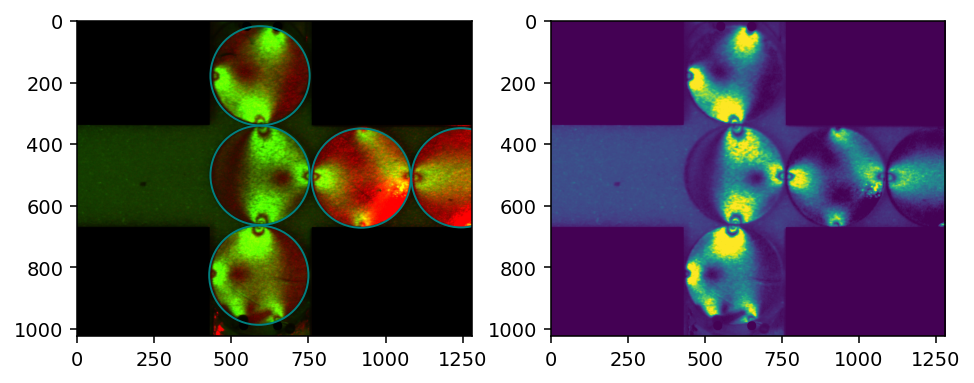

In [3]:
# Create a mask over the image, that will also be used to detect the boundary
maskXBounds = [430, 760] # Found manually
maskYBounds = [340, 670] # Found manually

# Account for any light gradients in the image
correctionImage = checkImageType(rootFolder + '2022-02-02_Calibration.bmp')
# For light correction, we want two separate images, one vertical and one horizontal
height, width = correctionImage.shape[:2]
verticalMask = np.array([[int(i < maskXBounds[1] and i > maskXBounds[0]) for i in range(width)] for j in range(height)])
horizontalMask = np.transpose([[int(i < maskYBounds[1] and i > maskYBounds[0]) for i in range(height)] for j in range(width)])

correction = lightCorrectionDiff(correctionImage, verticalMask, horizontalMask)

maskArr = crossMask(correctionImage.shape, xlim=np.array(maskXBounds), ylim=np.array(maskYBounds))

# Add in the pegs on the boundary particles
pegCenters = [[20, 550], [20, 650], [990, 540], [990, 650]]
pegRadii = 15

for i in range(len(pegCenters)):
    maskArr = maskArr - circularMask(correctionImage.shape, np.array(pegCenters[i]), pegRadii)
    
maskArr = maskArr > 0

# Make some fake data with several potential wall contacts
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

#image = checkImageType('test_data/Test_2022-01-28.bmp')
image = checkImageType(dataFolder + 'frame0220.bmp')

# g2 to force conversion is calibrated on the scale [0, 1], not [0, 255]
# We also blur the images a little, since they are visibly grainy
photoelasticChannel = cv2.blur(image[:,:,1].astype(np.float64) / 255, (3,3))

centers, radii = convCircle(image[:,:,0] * maskArr[:,:,0], guessRadius)

centers = centers.astype(np.int64)
radii = radii.astype(np.int64)
# Make them all odd
radii += (radii % 2) == 0

ax[0].imshow(maskArr * image)
for i in range(len(centers)):
    c = plt.Circle(centers[i][::-1], radii[i], label='Detected particles', color='teal', fill=False, linewidth=1)
    ax[0].add_artist(c)

ax[1].imshow(photoelasticChannel * maskArr[:,:,0])
plt.show()

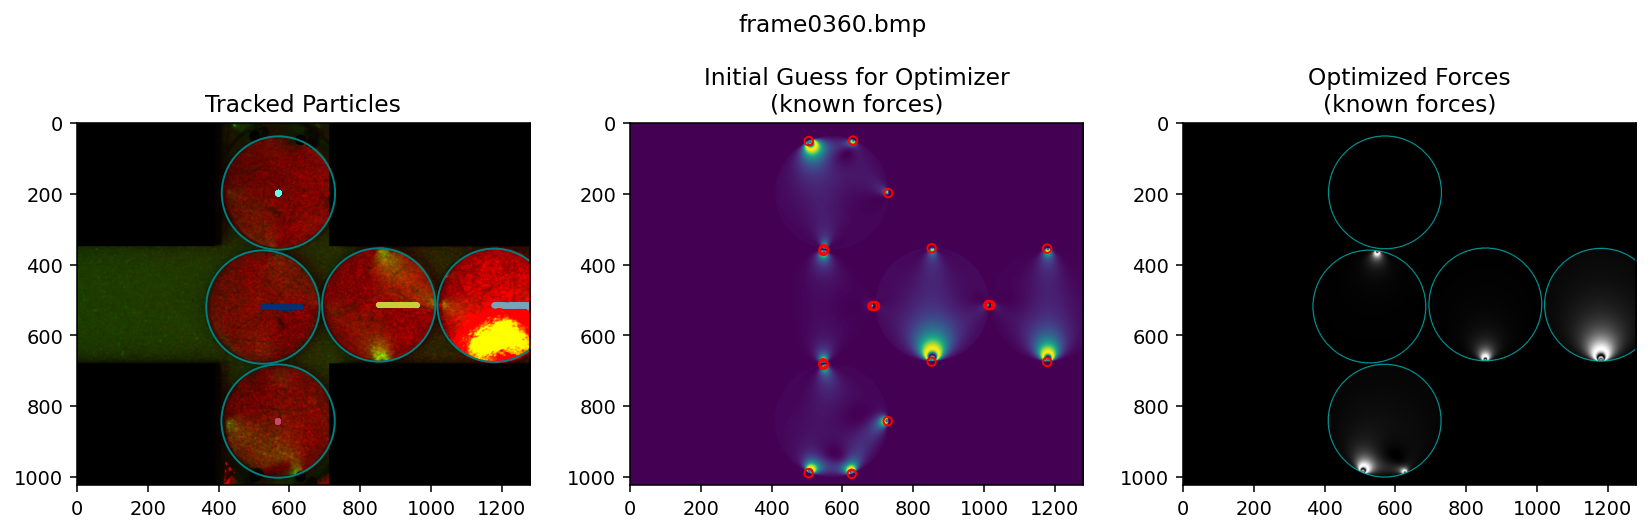

 99% (309 of 310) |#################### | Elapsed Time: 10:19:42 ETA:   0:01:27

Took 87.132s to solve frame:
     Tracking:         1.05s
     Initial guess:    1.09s
     Optimization:     74.0s
     Misc. processes:  11.0s


In [5]:
optimizationKwargs = {"maxEvals": [120, 100], "method": 'nelder',
                     "parametersToFit": [['f'], ['a']],
                     "allowRemoveForces": True, "alphaTolerance": .6,
                     "allowAddForces": True, "minForceThreshold": .03}

forceArr, alphaArr, betaArr, centerArr, radiusArr = forceSolve(rootFolder + dataFolder, guessRadius, fSigma, pxPerMeter,
                                                        brightfield, maskImage=maskImage, lightCorrectionImage=correctionImage,
                                                        lightCorrectionVerticalMask=verticalMaskImage,
                                                        lightCorrectionHorizontalMask=horizontalMaskImage,
                                                        g2CalibrationImage=g2CalibrationImage, g2CalibrationCutoffFactor=1.3,
                                                        imageStartIndex=50, imageEndIndex=360, carryOverAlpha=False,
                                                        debug=True, optimizationKwargs=optimizationKwargs, saveMovie=True, pickleArrays=True)

In [3]:
dataSet = '2022-02-28_Wide_Synthetic/'

with open(dataSet + 'forces.pickle', 'rb') as f:
    forceArr = pickle.load(f)
with open(dataSet + 'alphas.pickle', 'rb') as f:
    betaArr = pickle.load(f)
with open(dataSet + 'betas.pickle', 'rb') as f:
    alphaArr = pickle.load(f)
with open(dataSet + 'centers.pickle', 'rb') as f:
    centerArr = pickle.load(f)
with open(dataSet + 'radii.pickle', 'rb') as f:
    radiusArr = pickle.load(f)

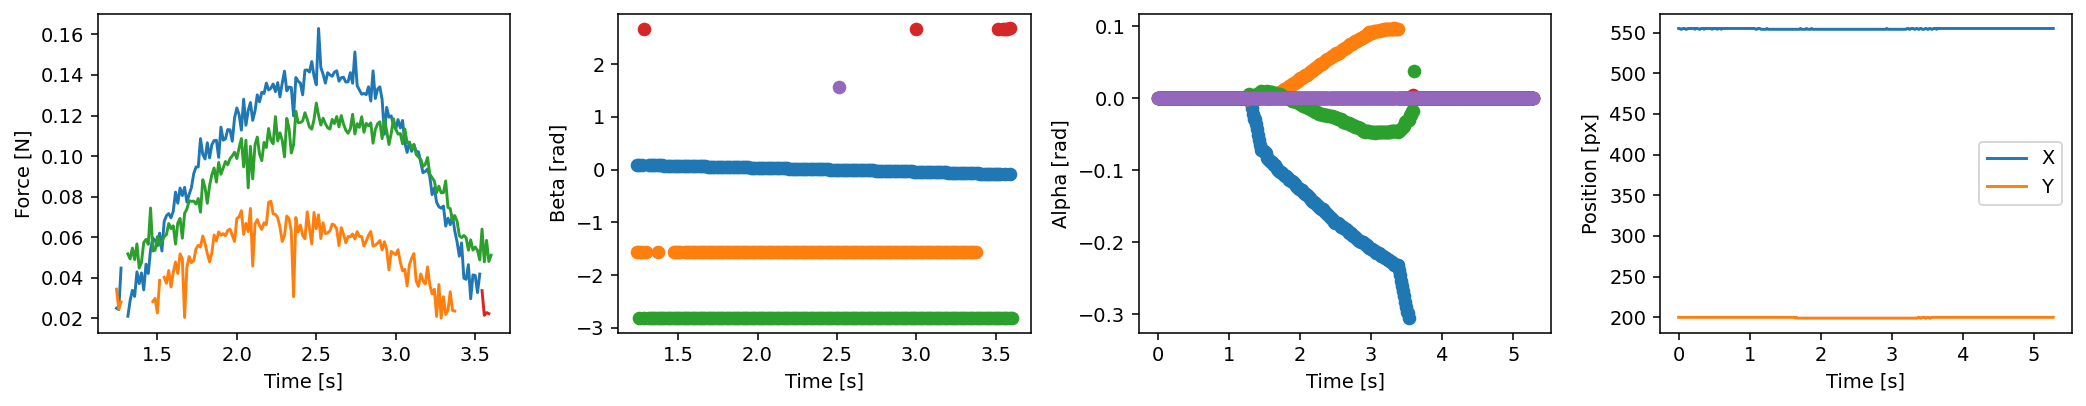

In [23]:
particleIndex = 3
fps = 70
tArr = np.arange(len(forceArr[3][0]))

fig, ax = plt.subplots(1, 4, figsize=(15,3))

ax[3].plot(tArr/fps, centerArr[particleIndex][:,1], label='X')
ax[3].plot(tArr/fps, centerArr[particleIndex][:,0], label='Y')

for i in range(len(betaArr[particleIndex])):
    ax[0].plot(tArr/fps, forceArr[particleIndex][i])
    ax[1].plot(tArr/fps, betaArr[particleIndex][i], 'o')
    ax[2].plot(tArr/fps, alphaArr[particleIndex][i], 'o')
    
ax[0].set_ylabel('Force [N]')
ax[1].set_ylabel('Beta [rad]')
ax[2].set_ylabel('Alpha [rad]')
ax[3].set_ylabel('Position [px]')
ax[3].legend()

for i in range(4):
    ax[i].set_xlabel('Time [s]')
    
fig.tight_layout()
plt.show()

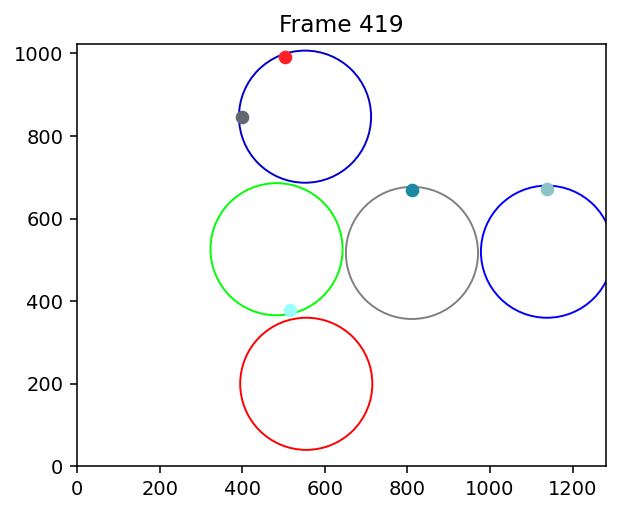

In [10]:
forceColors = [genRandomColors(len(b), int(time.perf_counter()*1e6) % 1024) for b in betaArr]
tSteps = len(betaArr[0][0])
images = [None for i in range(tSteps)]

for i in range(tSteps):
    clear_output(wait=True)
    fig, ax = plt.subplots()
    
    visCircles([centerArr[p][i] for p in range(len(centerArr))], [radiusArr[p][i] for p in range(len(radiusArr))], ax=ax)

    for particleIndex in range(len(betaArr)):
        visContacts(centerArr[particleIndex][i], radiusArr[particleIndex][i],
                    betaArr[particleIndex][:,i], ax=ax, forceColors=forceColors[particleIndex])#, alphaArr=alphaArr[particleIndex][:,i])
        
    ax.set_xlim([0, 1280])
    ax.set_ylim([0, 1024])
    ax.set_aspect('equal')
    ax.set_title(f'Frame {50 + i}')
    
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    images[i] = Image.frombytes('RGB', canvas.get_width_height(), 
                 canvas.tostring_rgb())
    plt.show()

images[0].save('contact_tracking.gif', save_all=True, append_images=images[1:], duration=25, optimize=True, loop=True)

In [20]:
forceColors = [genRandomColors(len(b), int(time.perf_counter()*1e6) % 1024) for b in betaArr]
tSteps = len(betaArr[0][0])
images = [None for i in range(tSteps)]
for i in range(len(alphaArr)):
    alphaArr[i][np.where(np.isnan(alphaArr[i]))] = 0

for i in range(tSteps):
    clear_output(wait=True)
    fig, ax = plt.subplots()
    
    visCircles([centerArr[p][i] for p in range(len(centerArr))], [radiusArr[p][i] for p in range(len(radiusArr))], ax=ax)

    for particleIndex in range(len(betaArr)):
        visContacts(centerArr[particleIndex][i], radiusArr[particleIndex][i],
                    betaArr[particleIndex][:,i], forceArr=forceArr[particleIndex][:,i], ax=ax, forceColors=forceColors[particleIndex], alphaArr=alphaArr[particleIndex][:,i])
        
    ax.set_xlim([0, 1280])
    ax.set_ylim([0, 1024])
    ax.set_aspect('equal')
    ax.set_title(f'Frame {50 + i}')
    
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    images[i] = Image.frombytes('RGB', canvas.get_width_height(), 
                 canvas.tostring_rgb())
    plt.show()

images[0].save('contact_angle_tracking.gif', save_all=True, append_images=images[1:], duration=25, optimize=True, loop=True)

KeyboardInterrupt: 